In [3]:
library(ArchR)
# library(Signac)
set.seed(1)
addArchRThreads(threads = 1)
addArchRGenome("mm10")
library(tidyverse)
library(here)
library(Seurat)
library(gt)
library(ChIPseeker)
library(TxDb.Mmusculus.UCSC.mm10.knownGene)
txdb <- TxDb.Mmusculus.UCSC.mm10.knownGene
library(clusterProfiler)
library(ReactomePA)
library(DOSE)
#plot track
library(scATACutils)
library(dplyr)
library(readr)
library(ggplot2)
library(org.Mm.eg.db)
library(ggpubr)

Loading required package: ggplot2

Loading required package: SummarizedExperiment

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    unio

In [ ]:
frag.files = c("./raw_data/TP12/frag_bap/final/alignments.possorted.tagged.bap.fragments.tsv.gz",
               "./raw_data/TP13/frag_bap/final/alignments.possorted.tagged.bap.fragments.tsv.gz",
              "./raw_data/TP14/frag_bap/final/alignments.possorted.tagged.bap.fragments.tsv.gz",
              "./raw_data/TP15/frag_bap/final/alignments.possorted.tagged.bap.fragments.tsv.gz")

In [ ]:
# Remember to add excludeChr para
ArrowFiles <- createArrowFiles(inputFiles = frag.files,
                               sampleNames = c("TP12","TP13","TP14","TP15"),
                               filterTSS = 4, 
                               filterFrags = 800,  
                               addTileMat = TRUE,
                               addGeneScoreMat = TRUE,
                               excludeChr = c("chrM"),
                               force = TRUE
                              )

In [4]:
ArrowFiles <- c("TP15.arrow","TP12.arrow","TP13.arrow","TP14.arrow")
Merged.proj <- ArchRProject(
  ArrowFiles = ArrowFiles, 
  outputDirectory = "Gonad.4samples",
  copyArrows = TRUE #This is recommened so that if you modify the Arrow files you have an original copy for later usage.
)

Using GeneAnnotation set by addArchRGenome(Mm10)!

Using GeneAnnotation set by addArchRGenome(Mm10)!

Validating Arrows...

Getting SampleNames...

1 
2 
3 
4 


Copying ArrowFiles to Ouptut Directory! If you want to save disk space set copyArrows = FALSE

1 
2 
3 
4 


Getting Cell Metadata...

1 
2 
3 
4 


Merging Cell Metadata...

Initializing ArchRProject...


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                  

ArchR logging to : ArchRLogs/ArchR-addDoubletScores-791120d3d1e3-Date-2021-12-16_Time-16-41-33.log
If there is an issue, please report to github with logFile!

2021-12-16 16:41:33 : Batch Execution w/ safelapply!, 0 mins elapsed.

2021-12-16 16:41:33 : TP15 (1 of 4) :  Computing Doublet Statistics, 0 mins elapsed.

Filtering 1 dims correlated > 0.75 to log10(depth + 1)

Filtering 1 dims correlated > 0.75 to log10(depth + 1)

Filtering 1 dims correlated > 0.75 to log10(depth + 1)

TP15 (1 of 4) : UMAP Projection R^2 = 0.99592

TP15 (1 of 4) : UMAP Projection R^2 = 0.99592



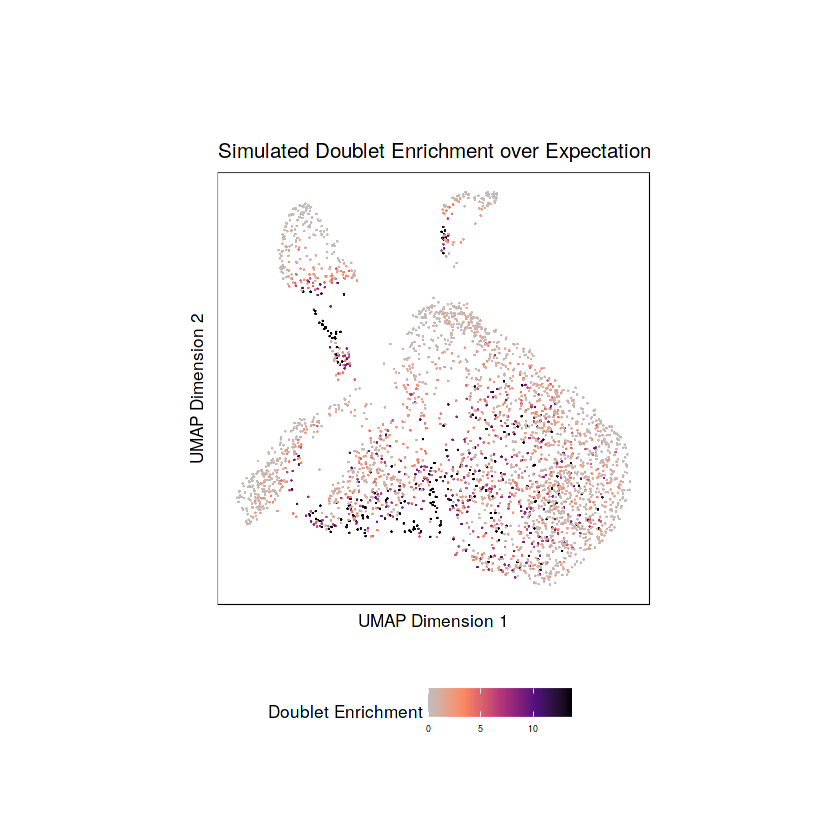

2021-12-16 16:46:20 : TP12 (2 of 4) :  Computing Doublet Statistics, 4.775 mins elapsed.

Filtering 1 dims correlated > 0.75 to log10(depth + 1)

TP12 (2 of 4) : UMAP Projection R^2 = 0.99298

TP12 (2 of 4) : UMAP Projection R^2 = 0.99298

2021-12-16 16:50:48 : TP13 (3 of 4) :  Computing Doublet Statistics, 9.252 mins elapsed.

TP13 (3 of 4) : UMAP Projection R^2 = 0.9956

TP13 (3 of 4) : UMAP Projection R^2 = 0.9956

2021-12-16 16:54:16 : TP14 (4 of 4) :  Computing Doublet Statistics, 12.722 mins elapsed.

Filtering 1 dims correlated > 0.75 to log10(depth + 1)

TP14 (4 of 4) : UMAP Projection R^2 = 0.99698

TP14 (4 of 4) : UMAP Projection R^2 = 0.99698

ArchR logging successful to : ArchRLogs/ArchR-addDoubletScores-791120d3d1e3-Date-2021-12-16_Time-16-41-33.log



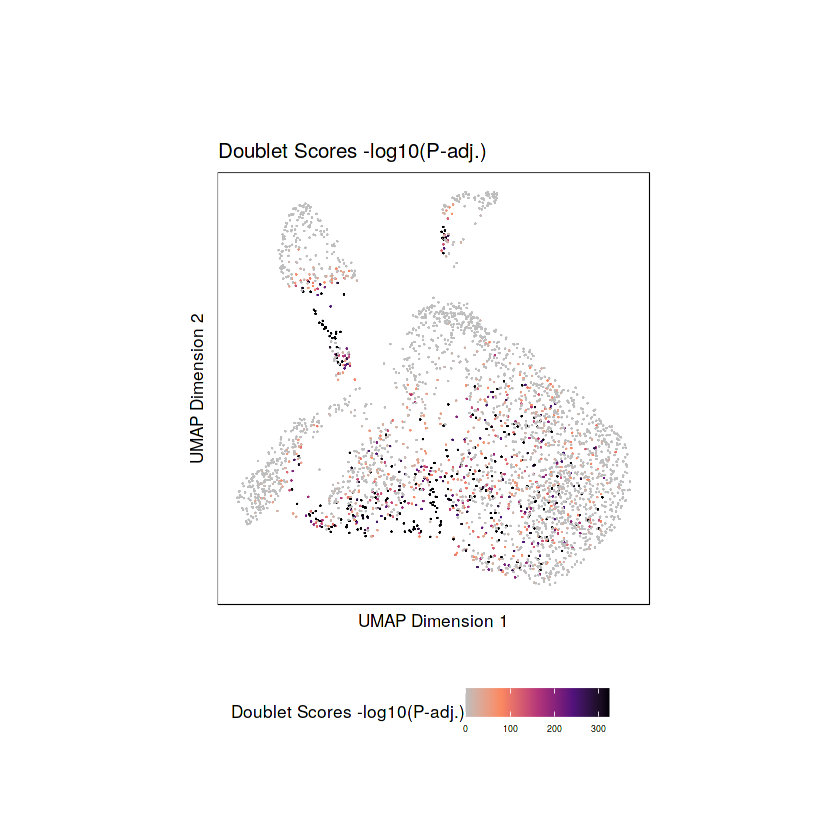

In [5]:
## Test Umap or LSI
#default
doubScores <- addDoubletScores(
    input = ArrowFiles,
    k = 10, #Refers to how many cells near a "pseudo-doublet" to count.
    knnMethod = "LSI", #Refers to the embedding to use for nearest neighbor search with doublet projection.
    LSIMethod = 1,
    threads=4,
    LSIParams = list(
        outlierQuantiles = c(0.02, 0.98), 
        filterBias = FALSE,iterations = 3, 
        UMAPParams = list(
        n_neighbors = 40, 
        min_dist = 0.4, 
        metric = "cosine", 
        verbose = FALSE, 
        fast_sgd = TRUE),
        clusterParams = list( #See Seurat::FindClusters
        resolution = c(1.5), 
        sampleCells = 10000, 
        n.start = 10,
        algorithm=2
    ), 
    varFeatures = 200000, 
    dimsToUse = 1:30),
    force = TRUE
)





In [6]:
Merged.proj


           ___      .______        ______  __    __  .______      
          /   \     |   _  \      /      ||  |  |  | |   _  \     
         /  ^  \    |  |_)  |    |  ,----'|  |__|  | |  |_)  |    
        /  /_\  \   |      /     |  |     |   __   | |      /     
       /  _____  \  |  |\  \\___ |  `----.|  |  |  | |  |\  \\___.
      /__/     \__\ | _| `._____| \______||__|  |__| | _| `._____|
    



class: ArchRProject 
outputDirectory: /home/leetl/sex_differentiation/Gonad.4samples 
samples(4): TP15 TP12 TP13 TP14
sampleColData names(1): ArrowFiles
cellColData names(15): Sample TSSEnrichment ... DoubletEnrichment
  BlacklistRatio
numberOfCells(1): 10010
medianTSS(1): 20.457
medianFrags(1): 10623

In [7]:
Merged.proj2 <- filterDoublets(Merged.proj,filterRatio = 1.2)

Filtering 308 cells from ArchRProject!

	TP15 : 118 of 3142 (3.8%)

	TP12 : 65 of 2339 (2.8%)

	TP13 : 45 of 1942 (2.3%)

	TP14 : 80 of 2587 (3.1%)



In [8]:
Merged.proj2


           ___      .______        ______  __    __  .______      
          /   \     |   _  \      /      ||  |  |  | |   _  \     
         /  ^  \    |  |_)  |    |  ,----'|  |__|  | |  |_)  |    
        /  /_\  \   |      /     |  |     |   __   | |      /     
       /  _____  \  |  |\  \\___ |  `----.|  |  |  | |  |\  \\___.
      /__/     \__\ | _| `._____| \______||__|  |__| | _| `._____|
    



class: ArchRProject 
outputDirectory: /home/leetl/sex_differentiation/Gonad.4samples 
samples(4): TP15 TP12 TP13 TP14
sampleColData names(1): ArrowFiles
cellColData names(15): Sample TSSEnrichment ... DoubletEnrichment
  BlacklistRatio
numberOfCells(1): 9702
medianTSS(1): 20.462
medianFrags(1): 10396

In [17]:
saveRDS(projHemeTmp@cellColData, file="gonad_4sample_nodoublet.rds")

In [19]:
saveArchRProject(ArchRProj = Merged.proj2, load = FALSE)

Saving ArchRProject...



In [3]:
Metadata.E18 <- readRDS(file="./QualityControl/TP12/TP12-Pre-Filter-Metadata.rds")
## Plot QC scatter plot manually
# pdf(file="P3.2-TSS_by_Unique_Frags.pdf",width=4,height=4,onefile=FALSE)
ggtitle <- sprintf("%s\n%s\n%s",
        paste0("E18", "\nnCells Pass Filter = ", sum(Metadata.E18$Keep)),
        paste0("Median Frags = ", median(Metadata.E18$nFrags[Metadata.E18$Keep==1])),
        paste0("Median TSS Enrichment = ", median(Metadata.E18$TSSEnrichment[Metadata.E18$Keep==1]))
      )
    gg.E18 <- ggPoint(
      x = pmin(log10(Metadata.E18$nFrags), 5) + rnorm(length(Metadata.E18$nFrags), sd = 0.00001),
      y = Metadata.E18$TSSEnrichment + rnorm(length(Metadata.E18$nFrags), sd = 0.00001), 
      colorDensity = TRUE,
      xlim = c(2.5, 5),
      ylim = c(0, max(Metadata.E18$TSSEnrichment) * 1.05),
      baseSize = 6,
      continuousSet = "sambaNight",
      xlabel = "Log 10 (Unique Fragments)",
      ylabel = "TSS Enrichment",
      title = ggtitle,
      rastr = TRUE) + 
      geom_hline(yintercept=4, lty = "dashed", size = 0.25) +
      geom_vline(xintercept=log10(1000), lty = "dashed", size = 0.25)
#     .fixPlotSize(gg, plotWidth = 4, plotHeight = 4)
# dev.off()
Metadata.P0 <- readRDS(file="./QualityControl/TP13/TP13-Pre-Filter-Metadata.rds")
## Plot QC scatter plot manually
# pdf(file="P3.2-TSS_by_Unique_Frags.pdf",width=4,height=4,onefile=FALSE)
ggtitle <- sprintf("%s\n%s\n%s",
        paste0("P0", "\nnCells Pass Filter = ", sum(Metadata.P0$Keep)),
        paste0("Median Frags = ", median(Metadata.P0$nFrags[Metadata.P0$Keep==1])),
        paste0("Median TSS Enrichment = ", median(Metadata.P0$TSSEnrichment[Metadata.P0$Keep==1]))
      )
    gg.P0 <- ggPoint(
      x = pmin(log10(Metadata.P0$nFrags), 5) + rnorm(length(Metadata.P0$nFrags), sd = 0.00001),
      y = Metadata.P0$TSSEnrichment + rnorm(length(Metadata.P0$nFrags), sd = 0.00001), 
      colorDensity = TRUE,
      xlim = c(2.5, 5),
      ylim = c(0, max(Metadata.P0$TSSEnrichment) * 1.05),
      baseSize = 6,
      continuousSet = "sambaNight",
      xlabel = "Log 10 (Unique Fragments)",
      ylabel = "TSS Enrichment",
      title = ggtitle,
      rastr = TRUE) + 
      geom_hline(yintercept=4, lty = "dashed", size = 0.25) +
      geom_vline(xintercept=log10(1000), lty = "dashed", size = 0.25)
#     .fixPlotSize(gg, plotWidth = 4, plotHeight = 4)
# dev.off()
Metadata.P3 <- readRDS(file="./QualityControl/TP14/TP14-Pre-Filter-Metadata.rds")
## Plot QC scatter plot manually
# pdf(file="P3.2-TSS_by_Unique_Frags.pdf",width=4,height=4,onefile=FALSE)
ggtitle <- sprintf("%s\n%s\n%s",
        paste0("P3", "\nnCells Pass Filter = ", sum(Metadata.P3$Keep)),
        paste0("Median Frags = ", median(Metadata.P3$nFrags[Metadata.P3$Keep==1])),
        paste0("Median TSS Enrichment = ", median(Metadata.P3$TSSEnrichment[Metadata.P3$Keep==1]))
      )
    gg.P3 <- ggPoint(
      x = pmin(log10(Metadata.P3$nFrags), 5) + rnorm(length(Metadata.P3$nFrags), sd = 0.00001),
      y = Metadata.P3$TSSEnrichment + rnorm(length(Metadata.P3$nFrags), sd = 0.00001), 
      colorDensity = TRUE,
      xlim = c(2.5, 5),
      ylim = c(0, max(Metadata.P3$TSSEnrichment) * 1.05),
      baseSize = 6,
      continuousSet = "sambaNight",
      xlabel = "Log 10 (Unique Fragments)",
      ylabel = "TSS Enrichment",
      title = ggtitle,
      rastr = TRUE) + 
      geom_hline(yintercept=4, lty = "dashed", size = 0.25) +
      geom_vline(xintercept=log10(1000), lty = "dashed", size = 0.25)
#     .fixPlotSize(gg, plotWidth = 4, plotHeight = 4)
# dev.off()
Metadata.P6 <- readRDS(file="./QualityControl/TP15/TP15-Pre-Filter-Metadata.rds")
## Plot QC scatter plot manually
# pdf(file="P3.2-TSS_by_Unique_Frags.pdf",width=4,height=4,onefile=FALSE)
ggtitle <- sprintf("%s\n%s\n%s",
        paste0("P6", "\nnCells Pass Filter = ", sum(Metadata.P6$Keep)),
        paste0("Median Frags = ", median(Metadata.P6$nFrags[Metadata.P6$Keep==1])),
        paste0("Median TSS Enrichment = ", median(Metadata.P6$TSSEnrichment[Metadata.P6$Keep==1]))
      )
    gg.P6 <- ggPoint(
      x = pmin(log10(Metadata.P6$nFrags), 5) + rnorm(length(Metadata.P6$nFrags), sd = 0.00001),
      y = Metadata.P6$TSSEnrichment + rnorm(length(Metadata.P6$nFrags), sd = 0.00001), 
      colorDensity = TRUE,
      xlim = c(2.5, 5),
      ylim = c(0, max(Metadata.P6$TSSEnrichment) * 1.05),
      baseSize = 6,
      continuousSet = "sambaNight",
      xlabel = "Log 10 (Unique Fragments)",
      ylabel = "TSS Enrichment",
      title = ggtitle,
      rastr = TRUE) + 
      geom_hline(yintercept=4, lty = "dashed", size = 0.25) +
      geom_vline(xintercept=log10(1000), lty = "dashed", size = 0.25)
#     .fixPlotSize(gg, plotWidth = 4, plotHeight = 4)
# dev.off()

In [9]:
pdf(file="Gonad.allcell.QC.TSS.scatter.plot.pdf",width=10,height=10)
gg.E18 + gg.P0 + gg.P3 + gg.P6
dev.off()

png 
  2